# Telco customer churn capstone
## Preparations
Summary of actions: 

Import data libraries and load dataset.

In [1]:
# Import libraries
# Data handling 
import numpy as np
import pandas as pd

# Statistical functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# General model-related functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Logistic regression
from sklearn.linear_model import LogisticRegression

# Random forest 
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix

In [2]:
# Load data
df = pd.read_csv("Telco-Customer-Churn.csv")

## Data inspection
##### Summary of actions: 

Display the first 10 rows of the dataset. Output the column names. Display the datatypes for each column.

In [3]:
# Display the first ten rows of the dataset
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df[:10])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [4]:
# Output the column names
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
# Output the column datatypes
def PrintColumnInfo(df):
    '''
    Function to display column datatypes in a tabular form with index, 
    column name, type and an example value. It's an alternative to df.dtypes 
    - I find the additional information helpful to my thought processes.
    '''
    template="%-8s %-30s %-8s %s"
    print(template % ("Index", "Column Name", "Type", "Example Value"))
    print("-"*62)
    for c in df.columns:
        print(template % (df.columns.get_loc(c), c, df[c].dtype, df[c].iloc[1]))

PrintColumnInfo(df)

Index    Column Name                    Type     Example Value
--------------------------------------------------------------
0        customerID                     object   5575-GNVDE
1        gender                         object   Male
2        SeniorCitizen                  int64    0
3        Partner                        object   No
4        Dependents                     object   No
5        tenure                         int64    34
6        PhoneService                   object   Yes
7        MultipleLines                  object   No
8        InternetService                object   DSL
9        OnlineSecurity                 object   Yes
10       OnlineBackup                   object   No
11       DeviceProtection               object   Yes
12       TechSupport                    object   No
13       StreamingTV                    object   No
14       StreamingMovies                object   No
15       Contract                       object   One year
16       PaperlessBilli

## Data preprocessing
##### Summary of actions:

Convert total charges to numeric. Remove rows with missing values. Remove customerID. Convert churn to binary. Convert categorical columns to dummy variables.


##### Acknowledgement:
This section was inspired by Sanila Wijesekara's approach to the dataset https://www.kaggle.com/code/sanilawijesekara/customer-churn-prediction-data-model-pipelines/notebook, although the code is all mine.

In [6]:
# Convert TotalCharges to numeric data type coercing missing or bad values 
# to NaN
df['TotalCharges'] = df[['TotalCharges']].apply(pd.to_numeric, errors='coerce')

In [7]:
# Remove rows with missing values
start = df.shape[0]
df.dropna(inplace=True)
end = df.shape[0]

print(
    f"There were {start} rows before dropping rows containing at least one NaN,"
    f" and {end} rows after. {start-end} rows were dropped."
)

There were 7043 rows before dropping rows containing at least one NaN, and 7032 rows after. 11 rows were dropped.


In [8]:
# Drop the customerID column
df.drop(['customerID'], axis=1, inplace=True)

In [9]:
# Convert Churn to a binary column with yes = 1 and no = 0
# Create Boolean masks
mask_yes = df['Churn'] == 'Yes'
mask_no = df['Churn'] == 'No'

# Substitute based on the masks
df.loc[mask_yes, 'Churn'] = 1
df.loc[mask_no, 'Churn'] = 0

# Convert Churn column to numeric
df['Churn'] = df[['Churn']].apply(pd.to_numeric)

### EDA/Feature engineering
Before one hot-encoding, perform preliminary EDA on the dataset and consider opportunities for feature engineering that would enhance the analysis later in this task. The column names suggest several of the columns are granular features that could be combined into one for simpler interpretation eg OnlineSecurity, OnlineBackup and DeviceProtection.

In [10]:
# Create list of categorical features
cat_feat = df.select_dtypes(include=['object']).columns.tolist()

# Display categories and values counts for each categorical variable
for cat in cat_feat:
    print(df[cat].value_counts())
    print()

gender
Male      3549
Female    3483
Name: count, dtype: int64

Partner
No     3639
Yes    3393
Name: count, dtype: int64

Dependents
No     4933
Yes    2099
Name: count, dtype: int64

PhoneService
Yes    6352
No      680
Name: count, dtype: int64

MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64

OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64

DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: count, dtype: int64

TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: count, dtype: int64

StreamingTV
No                 

Most of the variables are categorical. To jump straight to one hot-encoding for all these categorical variables will create many columns, which could create challenges for later interpretation of the analysis. With the stated goal being to predict customer churn, it seems several of these categories form a level of granularity in the data that isn't required.

In [11]:
# Create list of numerical features
num_feat = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Display unique values for each numerical variable
for num in num_feat:
    print(num)
    print(df[num].unique())
    print()

SeniorCitizen
[0 1]

tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]

MonthlyCharges
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]

TotalCharges
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]

Churn
[0 1]



SeniorCitizen is a categorical variable with values 0 or 1. Convert this column so it can be handled in the same fashion as the other categorical features.

In [12]:
# Make SeniorCitizen into a categorical variable
# Convert SeniorCitizen from int64 to str
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

# Replace 1 entries with 'Yes' and 0 entries with 'No'
df.loc[df['SeniorCitizen'] == '1', 'SeniorCitizen'] = 'Yes'
df.loc[df['SeniorCitizen'] == '0', 'SeniorCitizen'] = 'No'

# Move SeniorCitizen from num_feat to cat_feat
num_feat.remove('SeniorCitizen')
cat_feat.append('SeniorCitizen')

Churn is the dependent variable, not a feature, so remove it from the numerical features list.

In [13]:
num_feat.remove('Churn')

#### Categorical Feature Distributions

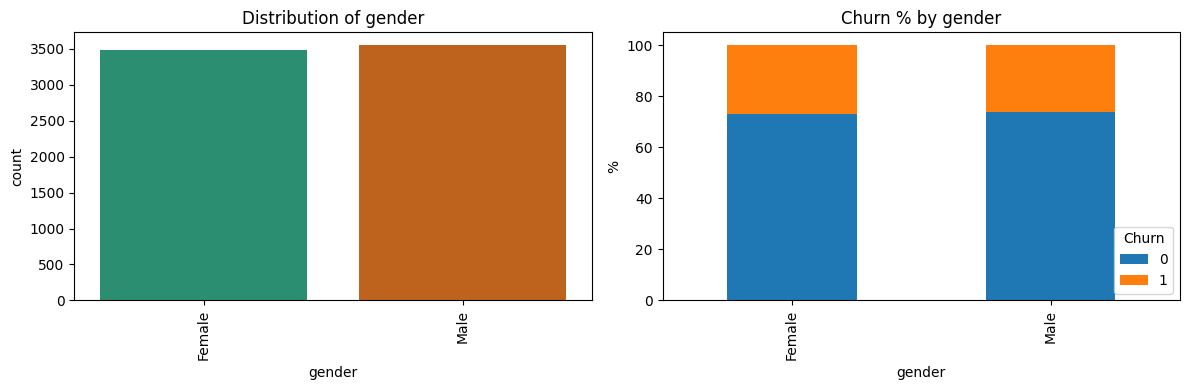

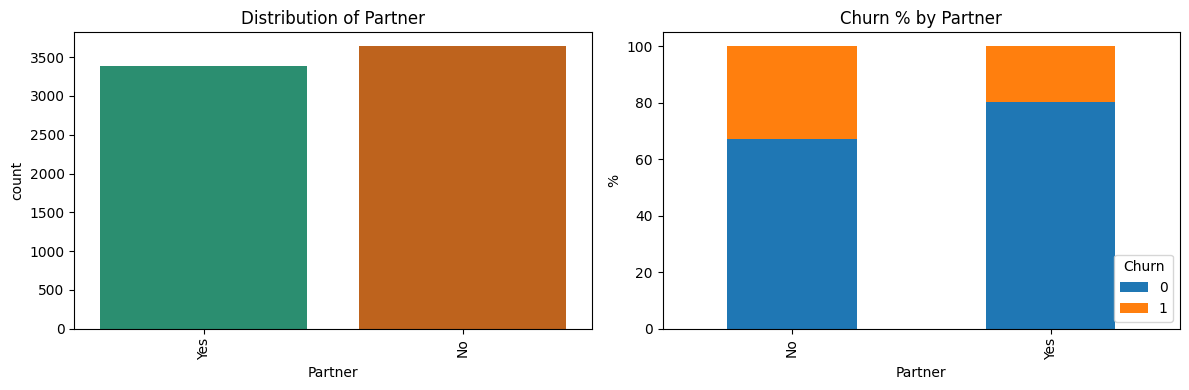

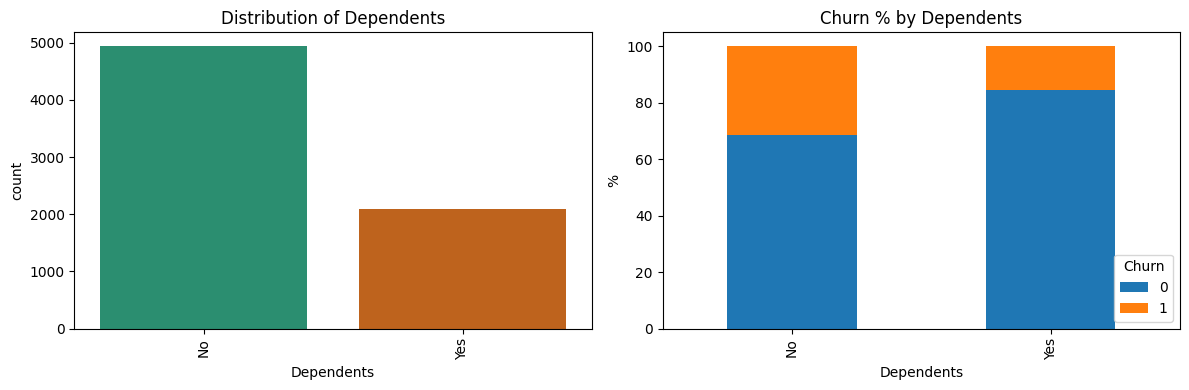

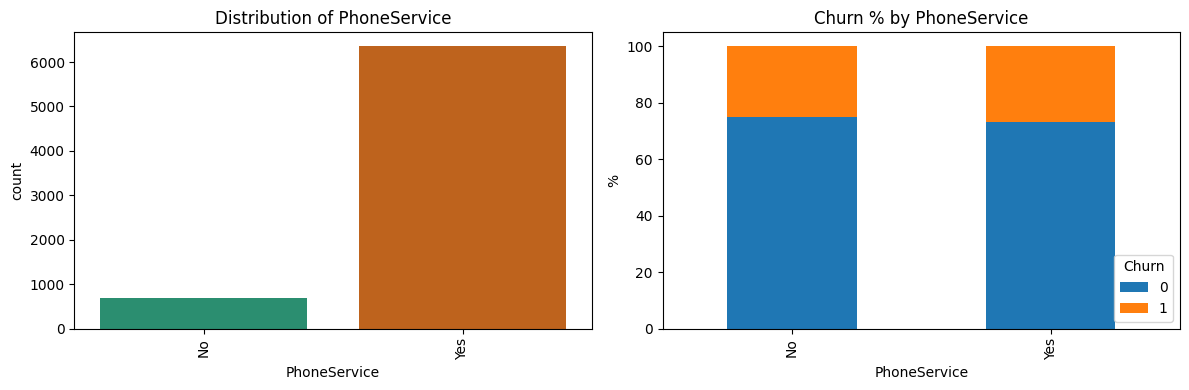

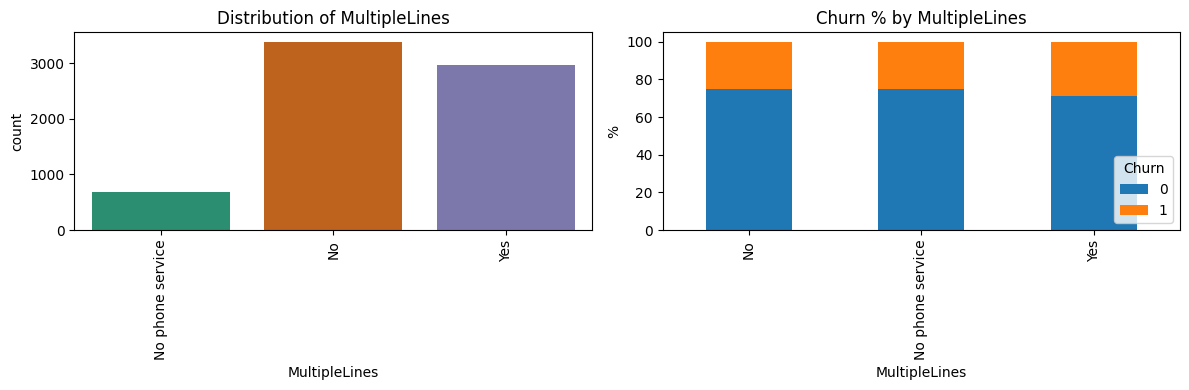

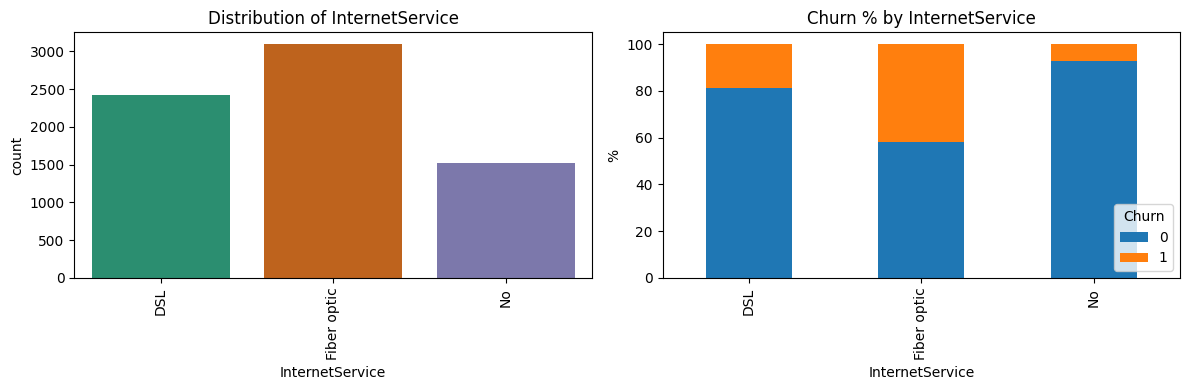

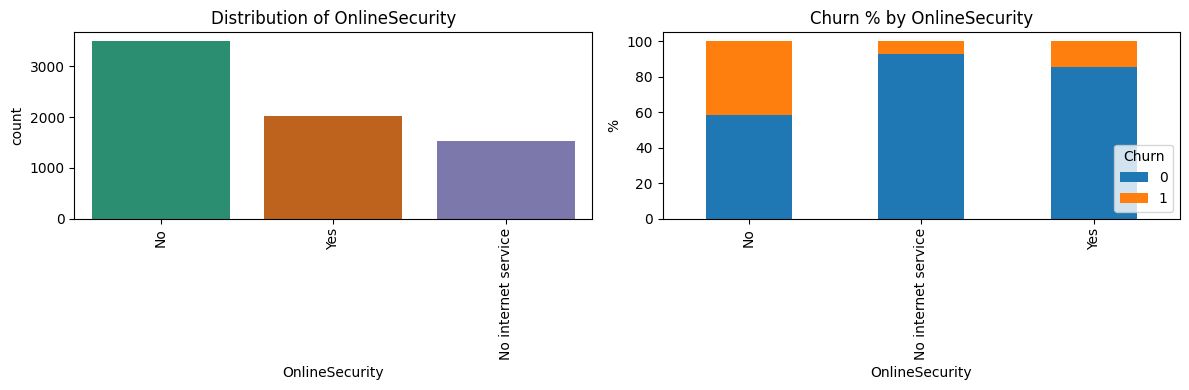

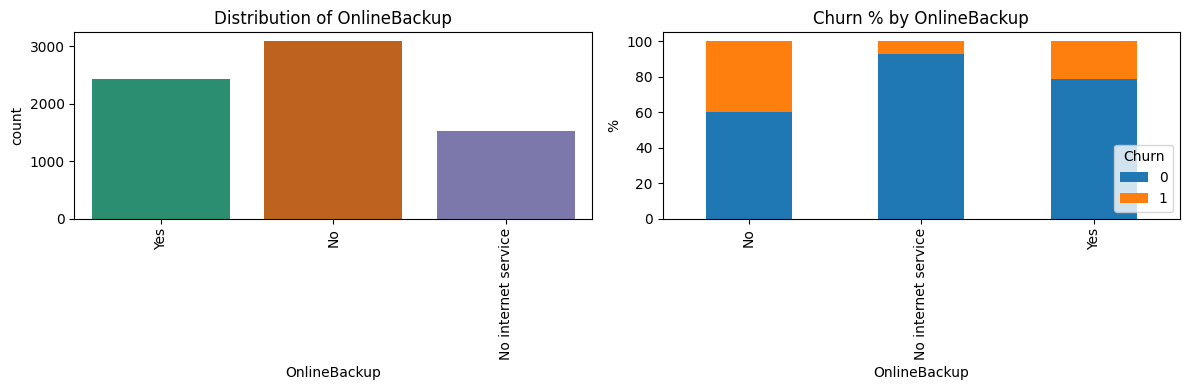

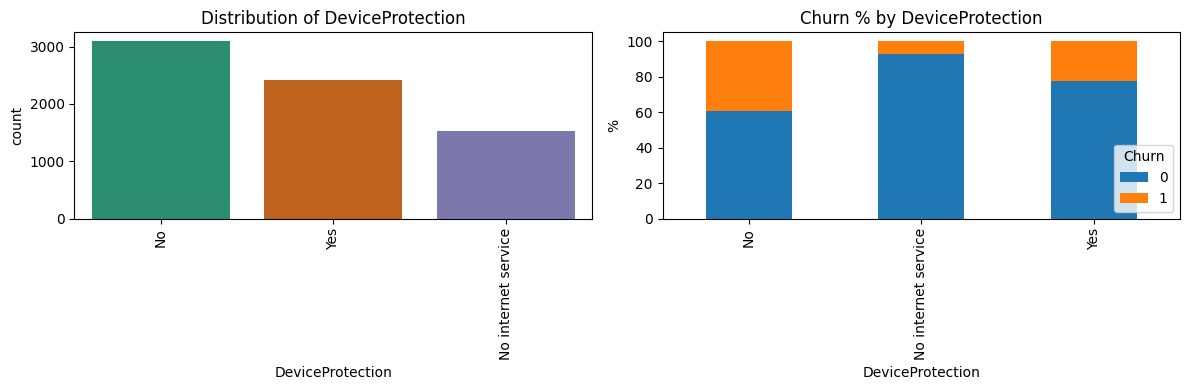

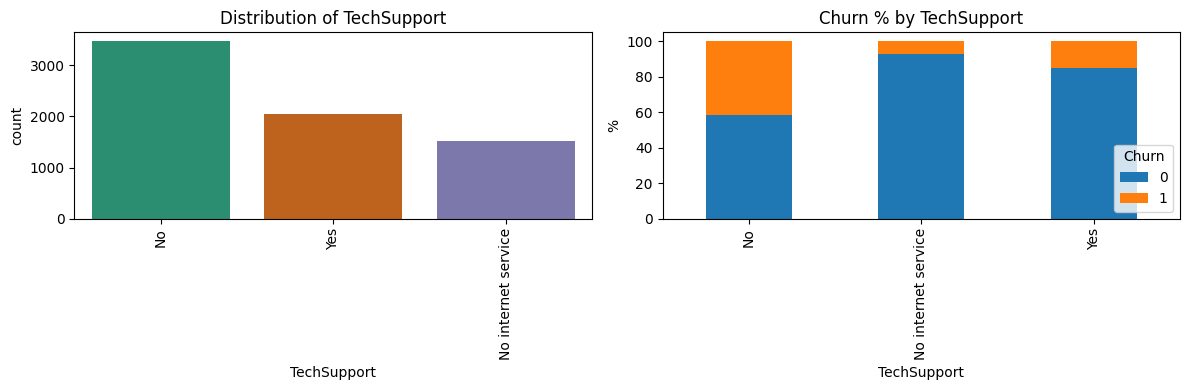

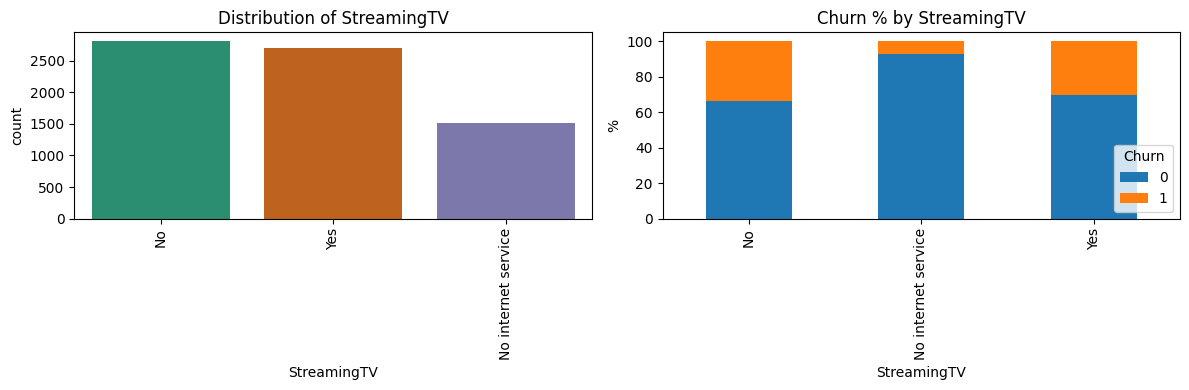

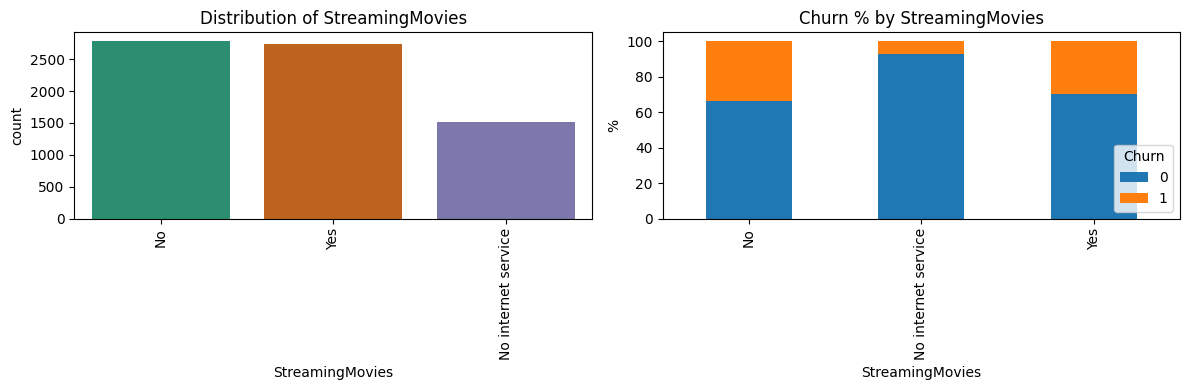

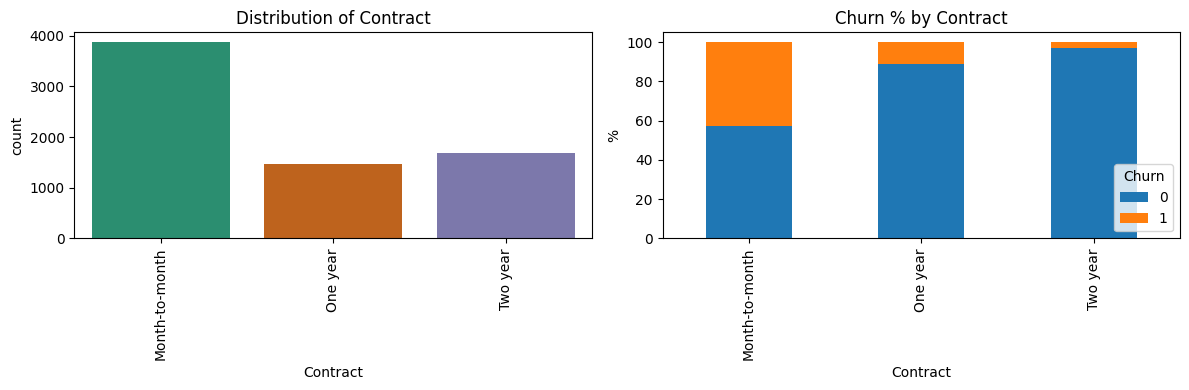

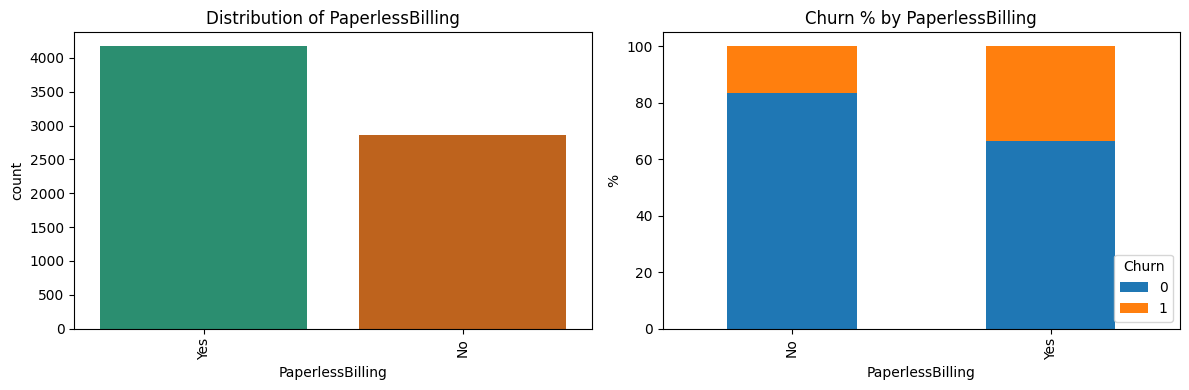

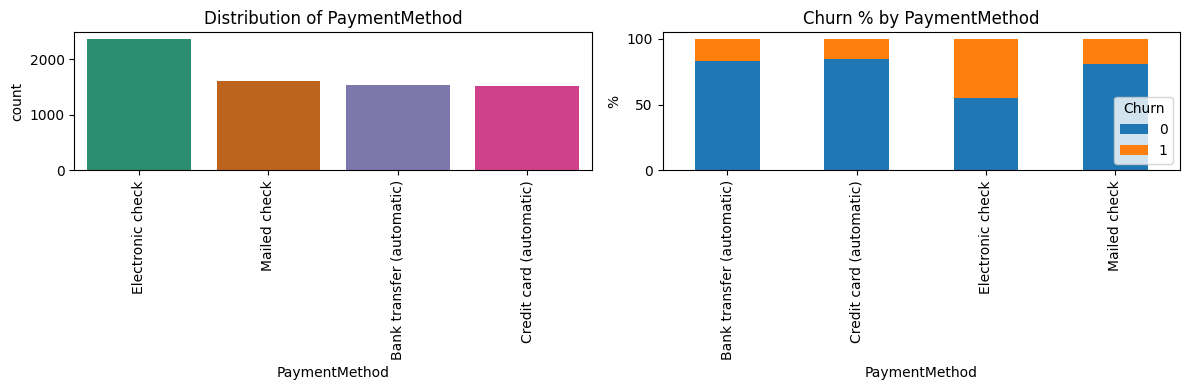

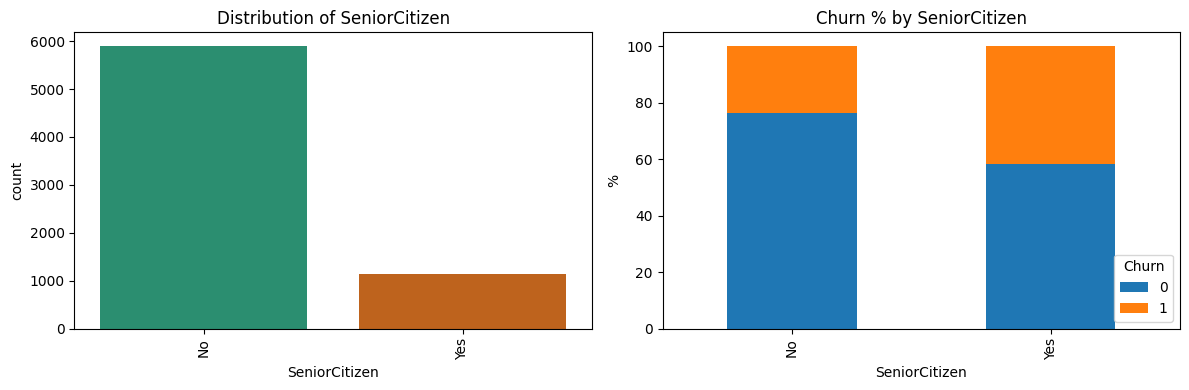

In [14]:
# Show category distributions for each feature and relate to Churn
for cat in cat_feat:
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Bar plot of value counts for each category value
    sns.countplot(
        x=cat, data=df, ax=axes[0], hue=cat, legend=False, palette='Dark2'
    )
    axes[0].set_title(f"Distribution of {cat}")
    axes[0].tick_params(axis='x', rotation=90)

    # Stacked bar plot showing Churn for each category value
    # Use crosstab function to create the temporary dataframe that enables the 
    # comparison
    churn_dist = pd.crosstab(df[cat], df['Churn'], normalize='index') * 100
    churn_dist.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title(f"Churn % by {cat}")
    axes[1].set_ylabel('%')
    plt.legend(title='Churn', loc='lower right')

    plt.tight_layout()

#### Numerical feature distributions

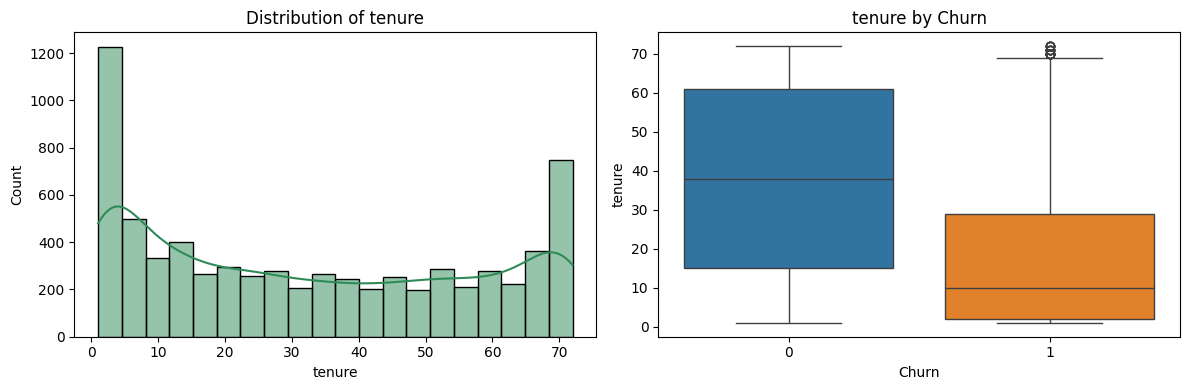

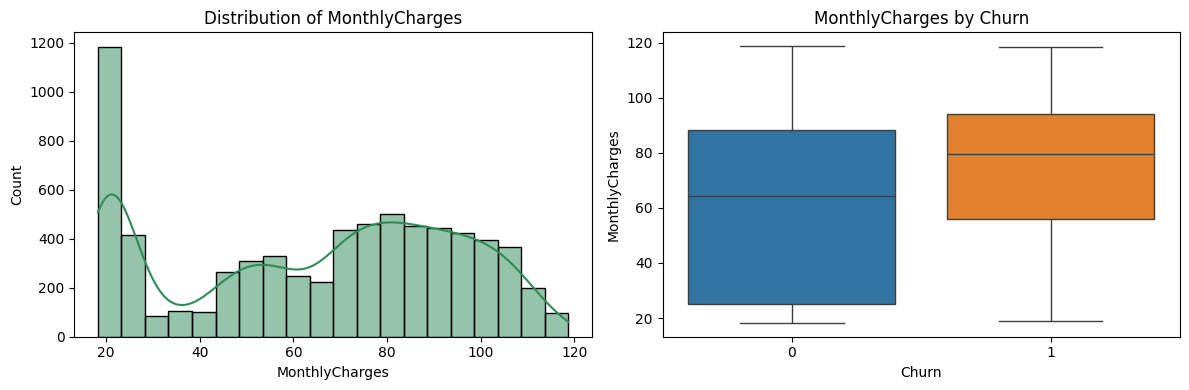

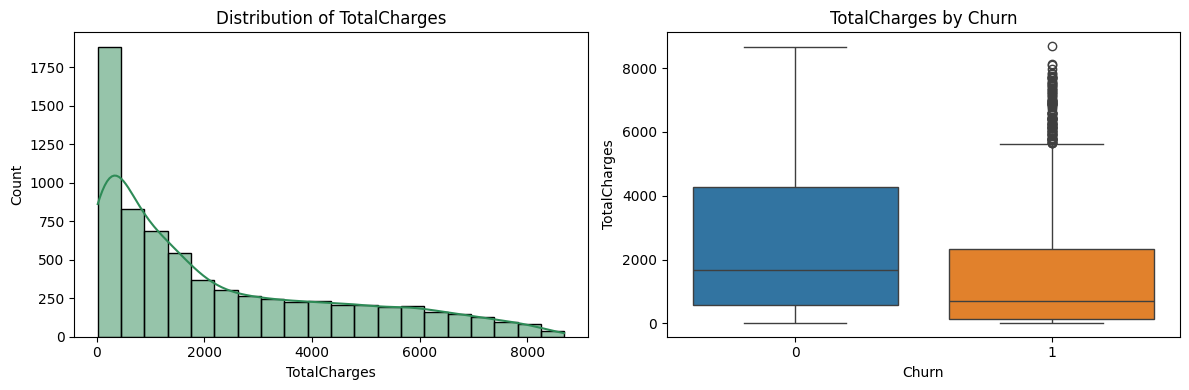

In [15]:
# Show numerical feature distributions and relate to Churn
for num in num_feat:
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram for each feature
    sns.histplot(df[num], bins=20, kde=True, ax=axes[0], color='seagreen')
    axes[0].set_title(f"Distribution of {num}")

    # Boxplots showing feature distribution by Churn
    sns.boxplot(x='Churn', y=num, data=df, hue='Churn', legend=False)
    axes[1].set_title(f"{num} by Churn")

    plt.tight_layout()

Both tenure and TotalCharges show outliers in the boxplots by Churn. Assess all numerical variables for outliers according to the 1.5IQR approach.

In [16]:
for num in num_feat:
    # Calculate interquartile range (IQR)
    Q1 = df[num].quantile(0.25)
    Q3 = df[num].quantile(0.75)
    IQR = Q3 - Q1

    # Find upper and lower bounds
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    # Find outliers
    outliers = df[(df[num] < lower) | (df[num] > upper)]

    # Display results
    print(f"{outliers.shape[0]} outliers found in {num}.")

0 outliers found in tenure.
0 outliers found in MonthlyCharges.
0 outliers found in TotalCharges.


No outliers in the numerical variable distributions.

### One hot-encoding

This particular dataset contains many and mostly categorical variables. Before creating new columns with `get_dummies()`, I will combine some of the features into new features.

The number of services a customer has is likely to more important to the model than the details of exactly which services they are. A customer with multiple services has to overcome greater inertia before switching to an alternative provider, simply due to the compounded inconvenience.

I will add two new features to describe customers with multiple services: NumServices = the number of services a customer has, which will be a number and Bundler = Boolean indication that a customer has internet and phone services (but not which exact ones).

Result interpretation reference https://tridenstechnology.com/telecom-churn/

In [17]:
# Create NumServices
services = [
    'PhoneService','MultipleLines','InternetService', 'OnlineSecurity',
    'OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
    'StreamingMovies'
]

# Count the services except InternetService
df['NumServices'] = (df[services] == "Yes").sum(axis=1)

# InternetService doesn't have a "Yes" category.
df.loc[df['InternetService'] != "No", 'NumServices'] += 1

<Axes: xlabel='NumServices', ylabel='count'>

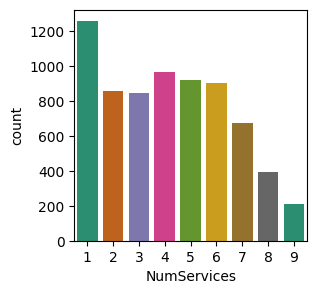

In [18]:
# Show the distribution of NumServices
# Prepare figure
fig = plt.figure(figsize=(3,3))

# Create bar chart
sns.countplot(
    x="NumServices", data=df, hue="NumServices", legend=False, palette='Dark2'
)

I was hoping some clear groupings may emerge, but to get groupings of similar sizes, it would be something like 1-2, 3-4, 5-6 and 7+. It feels important to know if the customer has 1 or 2 services. I could preserve most of that information with a new categorical feature "Bundler" which is yes if the customer has InternetService and PhoneService but no otherwise. This could conflate the cases of a customer having only telephone or only internet services into the same grouping as customers with a single service. I'm not sure that having NumServices available as a numeric column outweighs the disadvantages of the conflation.

An alternative approach would be to consider a higher level grouping of the categorical service variables. This could be PhoneService (Yes/No), InternetService (Yes/No) and Addons (Yes/No) where Addons includes all the other services. From this arrangement, we can interpret the results for phone or internet only users, those with both phone and internet, and those users who add higher value extras to their package. This seems like it would be a better option than the numeric column NumServices, so that is how I will proceed.

In [19]:
# Drop NumServices
df.drop("NumServices", axis=1, inplace=True)

In [20]:
# Combine InternetService = (DSL | Fiber optic) into yes
df.loc[df['InternetService'] != "No", 'InternetService'] = "Yes"

In [21]:
# Create addons list
addons = [
    'MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies'
]

In [22]:
# Populate addons column with default value "No"
df["Addons"] = "No"

# Locate rows with addons and change df["Addons"] to "Yes"
for item in addons:
    df.loc[df[item] == "Yes", "Addons"] = "Yes"

In [23]:
# Drop source columns for Addons
df.drop(columns=addons, inplace=True)

In [24]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Addons'],
      dtype='object')

In [25]:
cat_feat

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [26]:
# Update categorical feature list
cat_feat.append('Addons')

for item in addons:
    cat_feat.remove(item)

In [27]:
# Get dummy columns
telecom_cust_dummies = pd.get_dummies(df, columns=cat_feat, drop_first=True)

PrintColumnInfo(telecom_cust_dummies)

Index    Column Name                    Type     Example Value
--------------------------------------------------------------
0        tenure                         int64    34
1        MonthlyCharges                 float64  56.95
2        TotalCharges                   float64  1889.5
3        Churn                          int64    0
4        gender_Male                    bool     True
5        Partner_Yes                    bool     False
6        Dependents_Yes                 bool     False
7        PhoneService_Yes               bool     True
8        InternetService_Yes            bool     True
9        Contract_One year              bool     True
10       Contract_Two year              bool     False
11       PaperlessBilling_Yes           bool     False
12       PaymentMethod_Credit card (automatic) bool     False
13       PaymentMethod_Electronic check bool     False
14       PaymentMethod_Mailed check     bool     True
15       SeniorCitizen_Yes              bool     Fals

## Data visualisation

##### Summary of actions:

Correlation plot for the input variables and the output variable Churn. Create a histogram of Tenure. Create a scatterplot of MonthlyCharges vs TotalCharges. Create a boxplot to compare Tenure for churned and non-churned customers.

In [28]:
# Write function to find the correlation heatmap

def heatmap(data, col_ls, figx=8, figy=8):
    '''
    This function takes the dataframe 'data' and a list of columns to include 
    'col_ls' and calculates the correlation matrix. The function displays the 
    correlation heatmap at the passed figsize=(figx,figy).
    '''
    # Prepare dataframe of features to include
    X = data[col_ls]

    # Find the correlation matrix
    corr_X = X.corr(numeric_only=True)

    # Plot the heatmap
    fig = plt.figure(figsize=(figx,figy))
    sns.heatmap(corr_X, cmap="RdBu_r", annot=True, vmin=-1, vmax=1, square=True)
   
    return

In [29]:
# Update variable lists with new column names
cat_feat = [
    'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
    'InternetService_Yes', 'Contract_One year', 'Contract_Two year',
    'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
    'SeniorCitizen_Yes', 'Addons_Yes'
]

num_feat = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

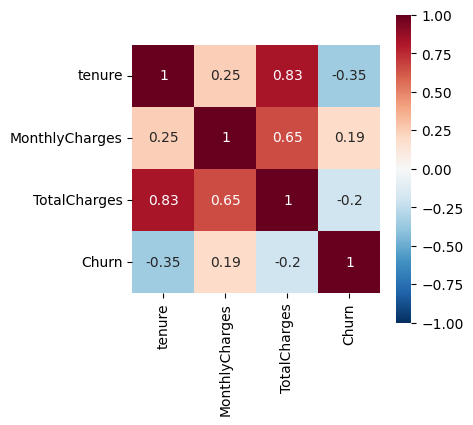

In [30]:
# Correlation heat map for numerical features
heatmap(telecom_cust_dummies, num_feat, 4, 4)

Stronger red hues in the heatmap indicate stronger positive correlations between variables and stronger blue hues indicate weaker negative correlations. The palest, offwhite hues indicate a null relationship. Models can be dominated by strong correlations between variables, reducing their predictive ability, while uncorrelated variables add computational cost without improving predictive ability.

##### Strong correlations to consider removing from the dataset (numerical features):
There is a very strong positive correlation between tenure and TotalCharges, and also between MonthlyCharges and TotalCharges. This is not surprising, since the TotalCharges is the sum of the MonthlyCharges during the tenure period.

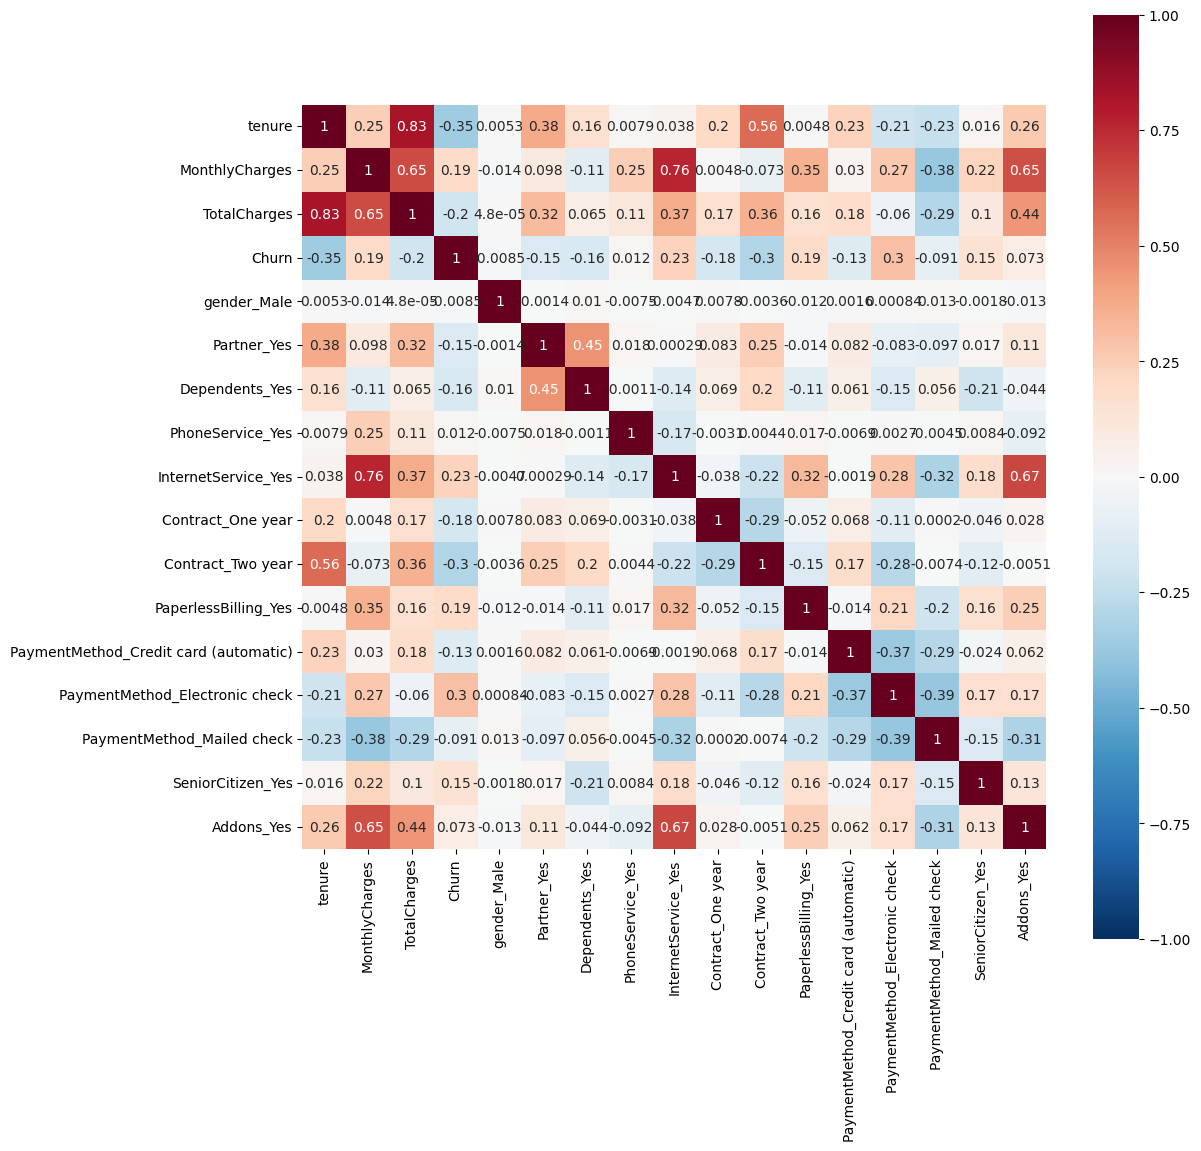

In [31]:
# Correlation heatmap for all features
all_cols = telecom_cust_dummies.columns.tolist()

heatmap(telecom_cust_dummies, all_cols, 12, 12)

##### Strong correlations to consider removing from the dataset (categorical features):
The heatmap highlights a strong positive correlation between InternetService_Yes and Addons_Yes, consistent with the MonthlyCharges increasing as services are added. There's also a positive correlation between Partner_Yes and Dependents_Yes, indicating cohabiting families.

##### Very weak and null correlations to consider removing from the dataset (categorical features):
The gender_Male correlations are all very pale, indicating that the gender of the account holder is irrelavent. PhoneService_Yes also has little impact on this dataset.


Before eliminating any variables, let's review the correlations just with Churn.

In [32]:
# Write function to find correlations for all the independent variables 
# with Churn
def corr_w_Churn(data):
    '''
    This function takes a dataframe, calculates the correlation matrix and then
    extracts only the correlations with Churn. The extracted correlations are 
    displayed in a simple plot.
    '''
    # Get the correlation matrix for all the variables
    corr = data.corr(numeric_only=True)

    # Extract the churn row
    churn_index = corr.columns.get_loc('Churn')
    corr_churn = corr.iloc[churn_index:churn_index+1, :]

    # Transpose the data for bar plot version
    corr_churn_tp = corr_churn.T

    # Plot
    fig = plt.figure()
    corr_churn_tp.plot(kind='bar', rot=90)

    return corr_churn_tp

<Figure size 640x480 with 0 Axes>

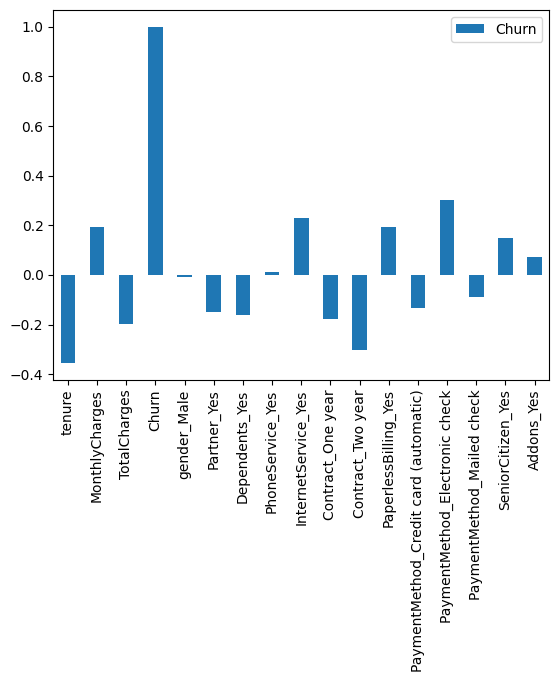

In [33]:
# Correlations with Churn
corr_churn_tp = corr_w_Churn(telecom_cust_dummies)

The above bar chart provides a graphical representation of the correlation factor between Churn and each of the independent variables. A correlation factor of +1 is a perfect positive correlation, -1 is a perfect negative correlation and 0 is the null correlation.

Considering very weak to null correlations as being in the range +/-0.1, there are null correlations between Churn and several variables listed below.

In [34]:
# Filter to select correlation factors +/-0.1
filter_out = corr_churn_tp[
    (corr_churn_tp['Churn'] < 0.1) & (corr_churn_tp['Churn'] > -0.1)
]
filter_out.sort_values('Churn', ascending=False)

,Churn
Addons_Yes,0.072728
PhoneService_Yes,0.011691
gender_Male,-0.008545
PaymentMethod_Mailed check,-0.090773


In [35]:
# Remove the null correlated variables
telecom_cust_dummies.drop(
    columns=[
        "Addons_Yes", "PhoneService_Yes", "gender_Male", 
        "PaymentMethod_Mailed check"
    ], axis=1, inplace=True
)

# Update categorical variable list
cat_feat.remove("Addons_Yes")
cat_feat.remove("PhoneService_Yes")
cat_feat.remove("gender_Male")
cat_feat.remove("PaymentMethod_Mailed check")

<Figure size 640x480 with 0 Axes>

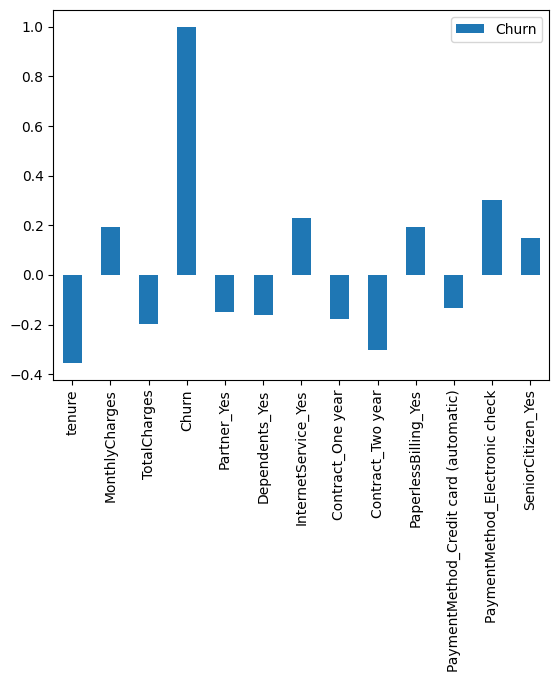

In [36]:
# Correlations with Churn (revised columns)
corr_churn_tp = corr_w_Churn(telecom_cust_dummies)

There are several variables with correlation coefficients with magnitude in the range 0.15 - 0.2. At this stage I don't have enough evidence to justify eliminating these from the model.

### Histogram of Tenure

Text(0.5, 1.0, 'Histogram of tenure')

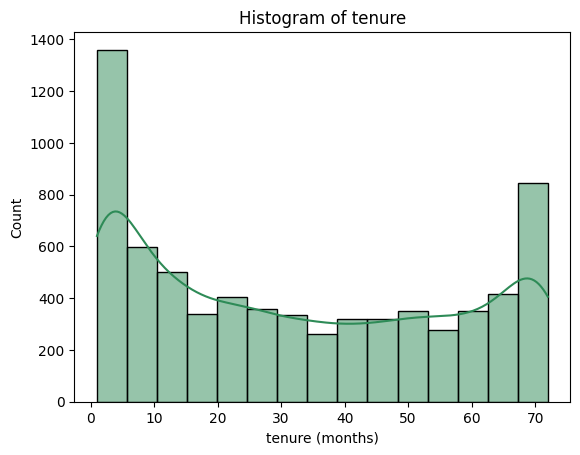

In [37]:
# Prepare figure
fig = plt.figure()

# Create histogram
sns.histplot(telecom_cust_dummies["tenure"], kde=True, color='seagreen')

# Add labels
plt.xlabel("tenure (months)")
plt.title("Histogram of tenure")

The tenure distribution between 12 and 65 months is uniform. The first and last bins are both significantly higher. In the case of the last bin, this could show the final data catagory has the form "tenure > x". The first bin has a significantly higher count than the others, indicating an influx of new customers, for example following a successful marketing campaign. The challenge the business faces now is how to retain that influx of customers. 

### Scattergraph of MonthlyCharges vs TotalCharges

Text(0.5, 1.0, 'Scatterplot of MonthlyCharges vs TotalCharges')

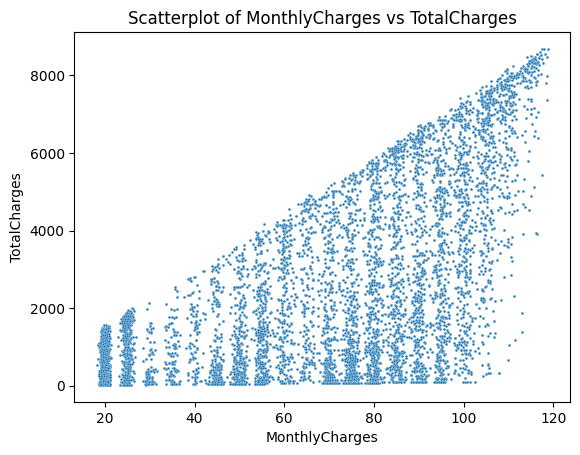

In [38]:
# Prepare figure
fig = plt.figure()

# Create scatter plot
sns.scatterplot(
    data=telecom_cust_dummies, x="MonthlyCharges", y="TotalCharges", s=4
)

# Add labels
plt.title("Scatterplot of MonthlyCharges vs TotalCharges")

The scatterplot above shows a strong positive correlation between TotalCharges and MonthlyCharges, as expected from the heatmap. TotalCharges is the sum of the MonthlyCharges during the tenure period. 

For thoroughness, I'll calculate and review the Variance Inflation Factor (VIF) for these variables. VIF = 1 for perfectly independent variables. VIF in the range 1-5 indicates a degree of correlation, which may be acceptable and actually what we are looking for. VIF in the range 5-10 indicates a strong correlation, with the potential to dominate the model. VIF >= 10 indicates multicollinearity that needs to be addressed.

Reference: https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b/

In [39]:
# Write function to compute VIF
def comp_vif(data, col_ls):
    '''
    This function takes the dataframe 'data' and a list of columns to include 
    'col_ls' and calculates VIF using the variance_inflation_factor method 
    for columns in the list. The function creates a dataframe of VIF for each 
    variable (ie column) and returns the dataframe, sorted by VIF.
    '''
    # Prepare dataframe of features to include
    X = data[col_ls].copy()
    
    # VIF calculation needs a constant
    X['const'] = 1

    # Prepare dataframe for results
    vif_df = pd.DataFrame()
    vif_df['Variable'] = X.columns

    # Calculate VIF as a new column
    vif_df['VIF'] =  [variance_inflation_factor(X.values, i) 
                      for i in range(X.shape[1])]
    vif_df = vif_df[vif_df['Variable'] != 'const']
    
    return vif_df.sort_values('VIF', ascending=False)    

In [40]:
# Find VIF using my function
# Columns to include
col_ls = num_feat

# Compute VIF
vif_df = comp_vif(telecom_cust_dummies, col_ls)
vif_df

,Variable,VIF
2,TotalCharges,9.719105
0,tenure,5.875290
1,MonthlyCharges,3.525402
3,Churn,1.289745


These results confirm my observation above that TotalCharges is a strongly correlated variable, possibly multicollinear, and should be removed from the model.

In [41]:
# Drop TotalCharges column
telecom_cust_dummies.drop(['TotalCharges'], axis=1, inplace=True)

# Update numerical feature list
num_feat.remove("TotalCharges")
num_feat.remove("Churn")

### Boxplot of tenure for Churn

[Text(0.5, 1.0, 'Boxplot to compare “tenure” for churned and non-churned customers')]

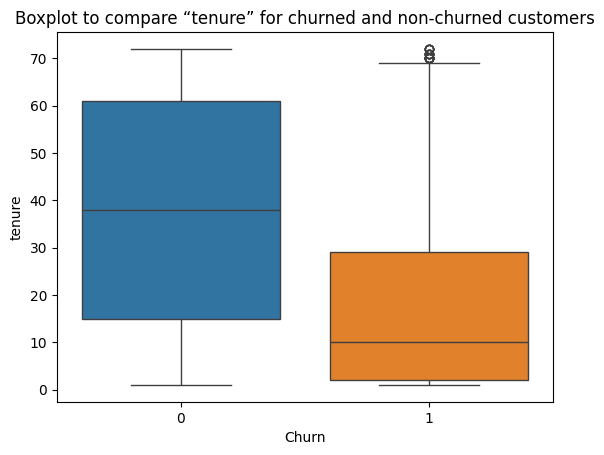

In [42]:
# Prepare figure
fig = plt.figure()

# Create boxplot
sns.boxplot(
    x='Churn', y='tenure', data=telecom_cust_dummies, hue='Churn', legend=False
).set(
    title="Boxplot to compare “tenure” for churned and non-churned customers"
)

Churn = 1 for churned customers. The boxplot shows that most churn occurs in less than 30 months of tenure. This could be related to the duration of a special price for new customers (eg 24 months).

Text(0.5, 1.0, 'Distribution of Churn')

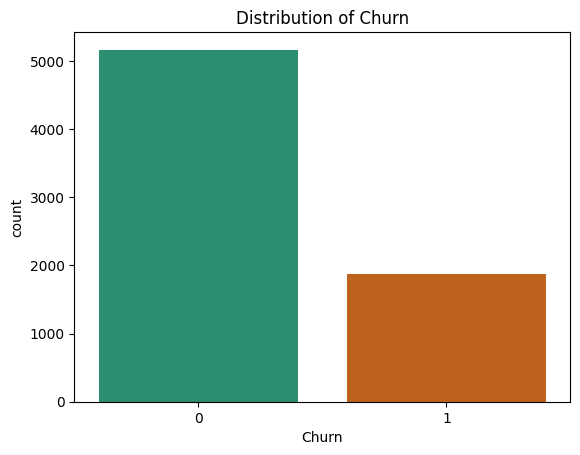

In [43]:
 # Bar plot of value counts for Churn
# Prepare figure
fig = plt.figure()

# Create bar chart
sns.countplot(x="Churn", data=df, hue="Churn", legend=False, palette='Dark2')

plt.title("Distribution of Churn")

The distribution of Churn values shows the dataset is imbalanced. There are three common approaches to address imbalance in the dataset.
1) set `class_weight='balanced'` in the model taking advantage of a built-in capability offered by scikit learn
2) undersample the majority class(es) to be of a similar size to the minority class(es)
3) oversample the minority class(es) by repeating records to achieve a similar size to the majority class(es).

Undersampling risks increasing the variance in the model by restricting the size of the training set. Oversampling risks overfitting. The class_weight argument adjusts the weights in inverse proportion to frequency. That is the method I will use for this task. 

### Feature distributions passed to model

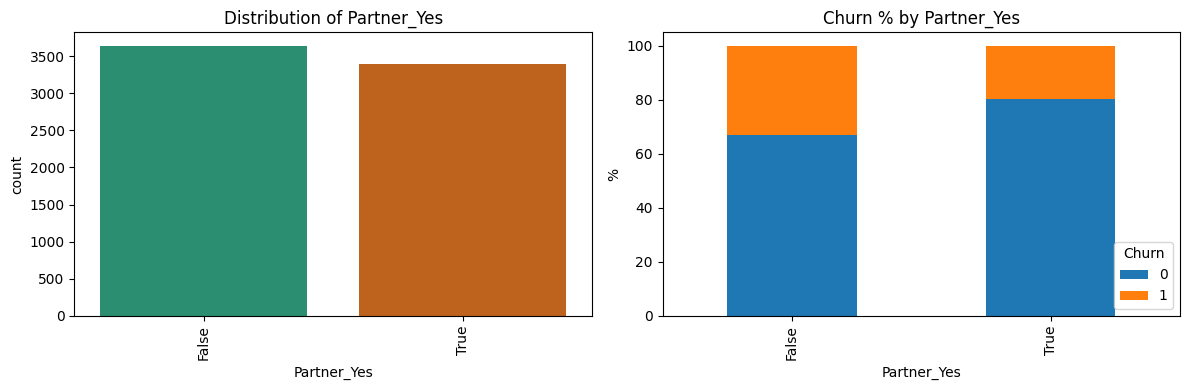

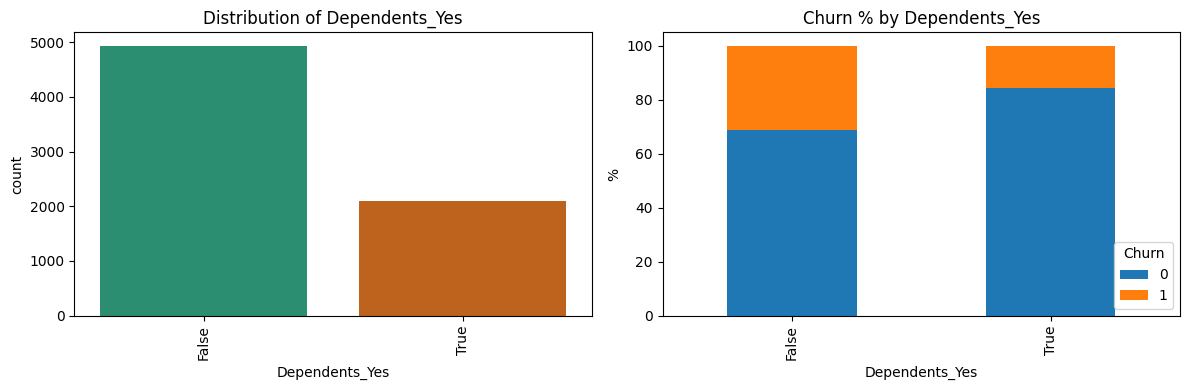

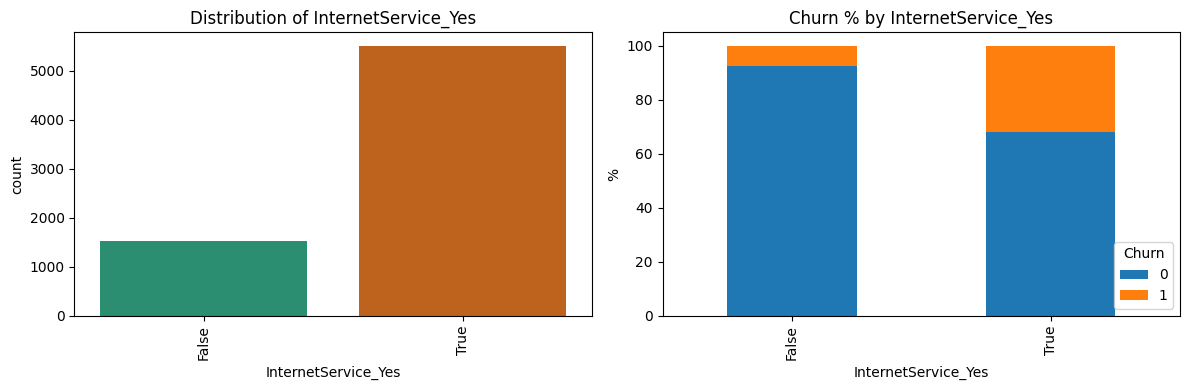

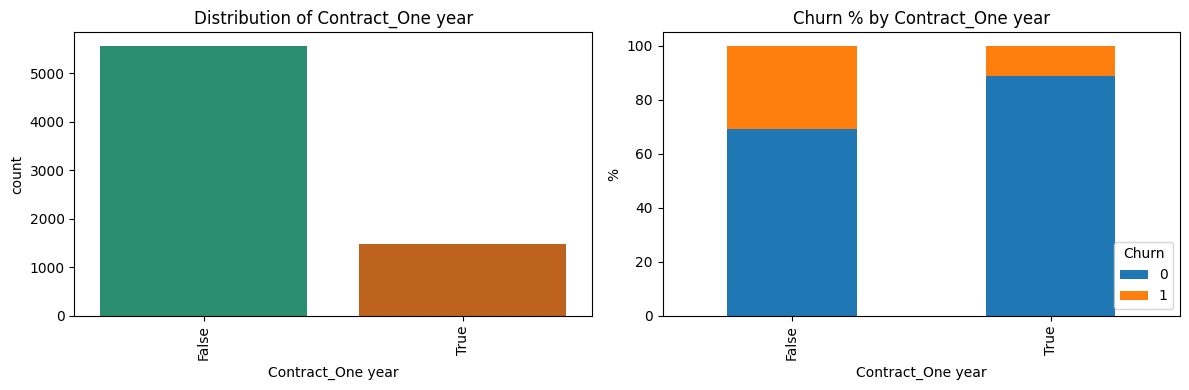

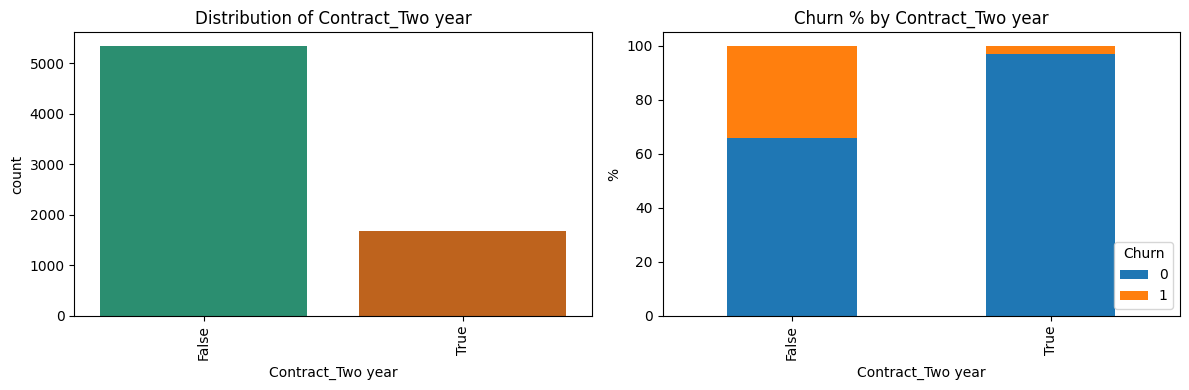

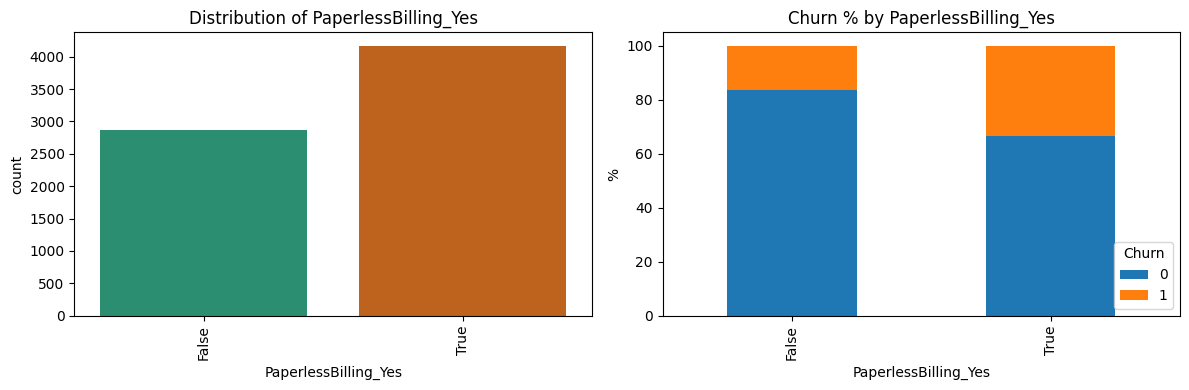

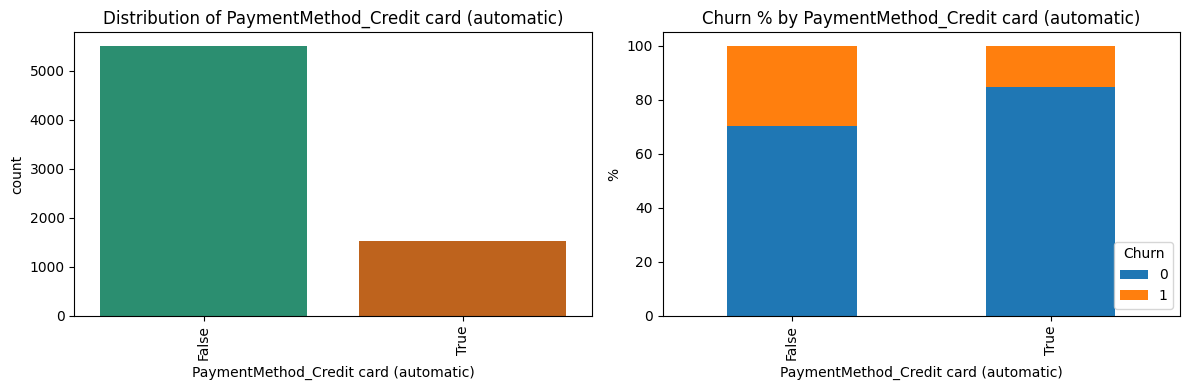

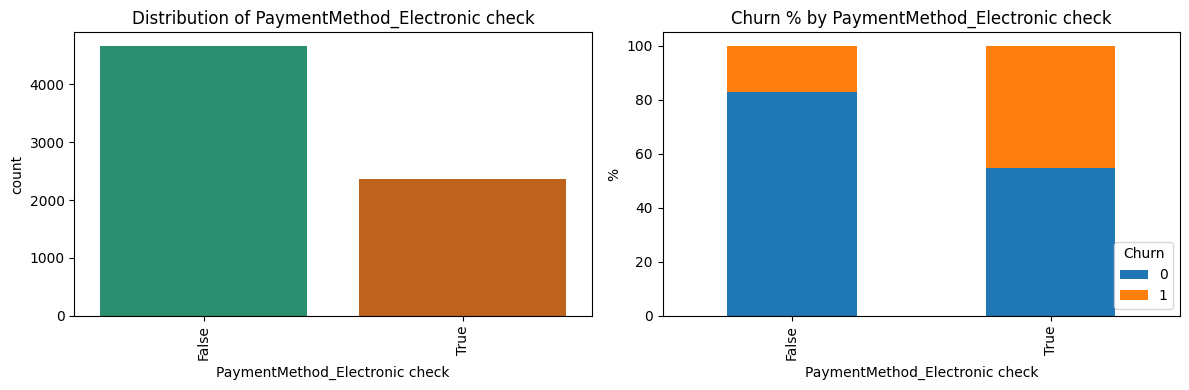

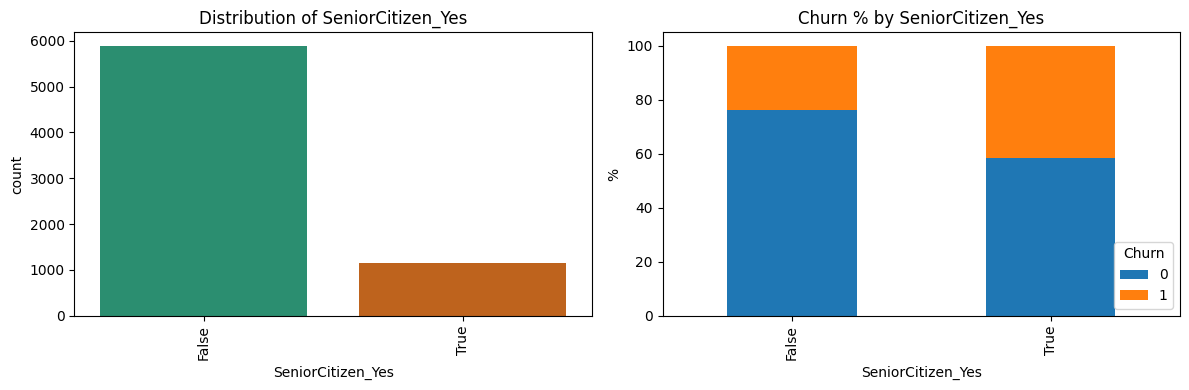

In [44]:
# Show category distributions for each feature and relate to Churn
for cat in cat_feat:
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Bar plot of value counts for each category value
    sns.countplot(
        x=cat, data=telecom_cust_dummies, ax=axes[0], 
        hue=cat, legend=False, palette='Dark2'
    )
    axes[0].set_title(f"Distribution of {cat}")
    axes[0].tick_params(axis='x', rotation=90)

    # Stacked bar plot showing Churn for each category value
    # Use crosstab function to create the temporary dataframe that enables 
    # the comparison
    churn_dist = pd.crosstab(
        telecom_cust_dummies[cat], telecom_cust_dummies['Churn'], 
        normalize='index'
    ) * 100
    churn_dist.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title(f"Churn % by {cat}")
    axes[1].set_ylabel('%')
    plt.legend(title='Churn', loc='lower right')

    plt.tight_layout()

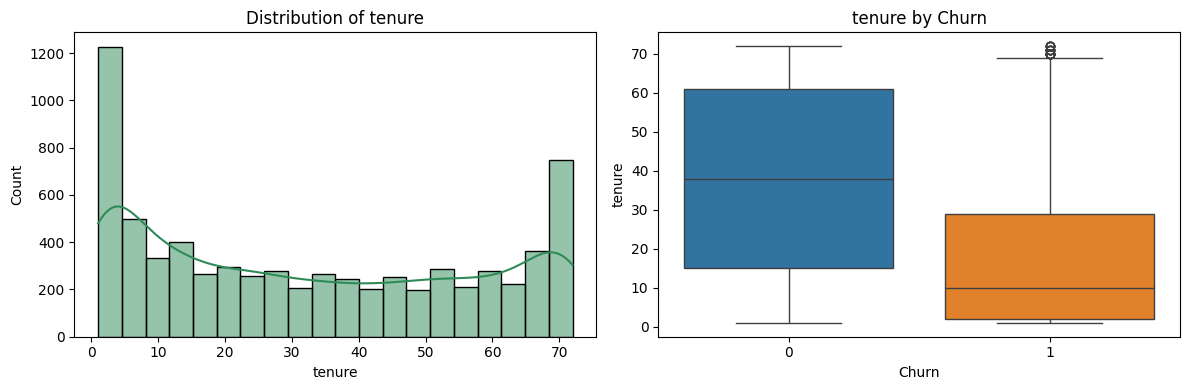

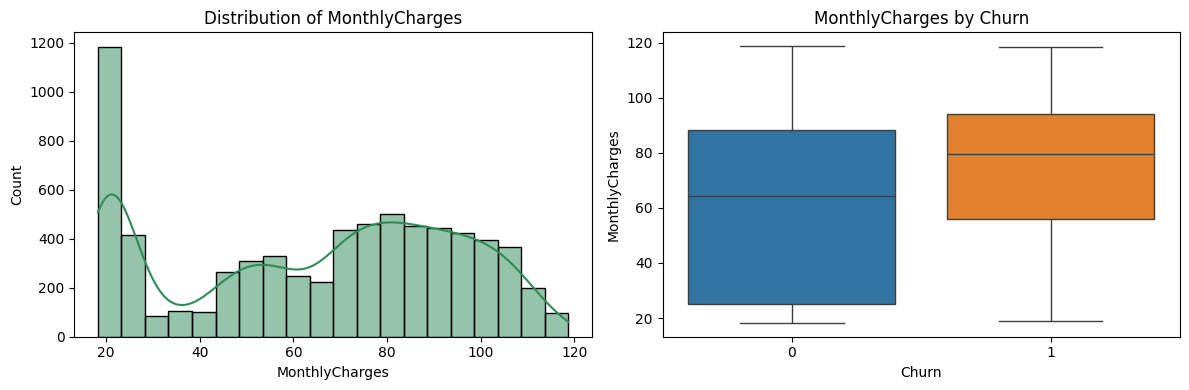

In [45]:
# Show numerical feature distributions and relate to Churn
for num in num_feat:
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram for each feature
    sns.histplot(df[num], bins=20, kde=True, ax=axes[0], color='seagreen')
    axes[0].set_title(f"Distribution of {num}")

    # Boxplots showing feature distribution by Churn
    sns.boxplot(x='Churn', y=num, data=df, hue='Churn', legend=False)
    axes[1].set_title(f"{num} by Churn")

    plt.tight_layout()

## Preparations for ML training

##### Summary of actions:

Scale all variables using min-max scaling. Split data into training and test sets.

If the numerical columns are scaled using all the data, there is potential for leakage from the test data to the training data. I prefer to split the data first, base the scaling on the training data only and then apply that same transformation to the test data.

In [46]:
# Define input independent variables X and output dependent variable y
X = telecom_cust_dummies.drop('Churn', axis=1)
y = telecom_cust_dummies['Churn'].values

Split the dataset into training and test sets (X_train; X_test; y_train; y_test) with a test size of 25%.

In [47]:
# Split data into training, development and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [48]:
# Convert tenure to float64 before scaling
X_train["tenure"] = X_train["tenure"].astype(float)
X_test["tenure"] = X_test["tenure"].astype(float)

In [49]:
# Apply MinMaxScaler() to tenure in training data
# Prepare data in individual columns
tenure_train = pd.DataFrame(X_train["tenure"])
tenure_test = pd.DataFrame(X_test["tenure"])

scaler = MinMaxScaler()
tenure_train_scaled = scaler.fit_transform(tenure_train)

# Apply the same transformation to test data
tenure_test_scaled = scaler.transform(tenure_test)

# Update X_train and X_test with scaled tenure
X_train.iloc[:,:1] = tenure_train_scaled
X_test.iloc[:,:1] = tenure_test_scaled

In [50]:
# Apply MinMaxScaler() to MonthlyCharges in training data
# Prepare data in individual columns
charges_train = pd.DataFrame(X_train["MonthlyCharges"])
charges_test = pd.DataFrame(X_test["MonthlyCharges"])

scaler = MinMaxScaler()
charges_train_scaled = scaler.fit_transform(charges_train)

# Apply the same transformation to test data
charges_test_scaled = scaler.transform(charges_test)

# Update X_train_all and X_test with scaled tenure
X_train.iloc[:,1:2] = charges_train_scaled
X_test.iloc[:,1:2] = charges_test_scaled

## Logistic Regression Model
##### Summary of actions:

Import and train a logistic regression model. Make predictions. Calculate and print the accuracy score.

In [51]:
# Fit a logistic regression model to X_train
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [52]:
# Predictions from X_test
y_pred_log = log_reg.predict(X_test).reshape(-1,1)

In [53]:
# Write function to find and display model accuracy
def PrintAccuracy(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    print(f"The accuracy score for the model is:\n    {round(acc, 5)}")
    return acc

In [54]:
# Accuracy score for this model
print("Logistic regression")
log_reg_acc = PrintAccuracy(y_test, y_pred_log)

Logistic regression
The accuracy score for the model is:
    0.74289


## Random forest model

##### Summary of actions:

Create and fit a random forest classifier. Make predictions. Calculate the accuracy score. Find and discuss the out of bag error (OOB) estimation.

In [55]:
# Create random forest classifier
forest = rfc(
    class_weight='balanced', 
    n_estimators=2000, 
    oob_score=True, 
    max_features="sqrt",
    max_leaf_nodes=50, 
    bootstrap=True,
    random_state=16
)

In [56]:
# Fit random forest on training data
forest.fit(X_train, y_train)

,n_estimators,2000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [57]:
# Find feature importance for the random forest
feature_imp = pd.Series(
    forest.feature_importances_
).sort_values(ascending=False)
feature_imp

0     0.308550
6     0.203538
1     0.156784
9     0.097601
5     0.085989
4     0.069599
7     0.030246
10    0.017558
3     0.011793
2     0.010458
8     0.007884
dtype: float64

In [58]:
PrintColumnInfo(X_train)

Index    Column Name                    Type     Example Value
--------------------------------------------------------------
0        tenure                         float64  0.18309859154929578
1        MonthlyCharges                 float64  0.6766317887394121
2        Partner_Yes                    bool     False
3        Dependents_Yes                 bool     False
4        InternetService_Yes            bool     True
5        Contract_One year              bool     False
6        Contract_Two year              bool     False
7        PaperlessBilling_Yes           bool     True
8        PaymentMethod_Credit card (automatic) bool     False
9        PaymentMethod_Electronic check bool     True
10       SeniorCitizen_Yes              bool     False


The least important features for the random forest model have feature importance < 0.05:
* PaymentMethod_Credit card (automatic) (index=8)
* SeniorCitizen_Yes (index=10)
* Dependents_Yes (index=3)
* Partner_Yes (index=2)
* PaperlessBilling_Yes (index=7)

These features do not add useful information for the model and can be dropped to improve the performance of the model without sacrificing predictive ability.

Drop these columns and retrain the model.

In [59]:
# List of columns
col_ls = [
    'PaymentMethod_Credit card (automatic)', 'Partner_Yes', 'Dependents_Yes', 
    'SeniorCitizen_Yes', 'PaperlessBilling_Yes'
]

# Drop columns
X_1_train = X_train.drop(columns=col_ls, axis=1)
X_1_test = X_test.drop(columns=col_ls, axis=1)

In [60]:
# Retrain both models on the reduced feature set
log_reg.fit(X_1_train, y_train)
forest.fit(X_1_train, y_train)

,n_estimators,2000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [61]:
# Predictions from X_1_test
y_pred_log_reg = log_reg.predict(X_1_test).reshape(-1,1)
y_pred_forest = forest.predict(X_1_test).reshape(-1,1)

In [62]:
# Accuracy scores for each model
print("Logistic Regression")
log_reg_acc = PrintAccuracy(y_test, y_pred_log_reg)

print("\nRandom Forest")
forest_acc = PrintAccuracy(y_test, y_pred_forest)

Logistic Regression
The accuracy score for the model is:
    0.73891

Random Forest
The accuracy score for the model is:
    0.76507


### OOB error estimation
The forest model was trained with bootstrap aggregation ie each tree in the forest is fitted from a subsample of training observations. The subsamples are created with replacement, which means some datapoints could appear more than once in the fitting of a particular tree, and other datapoints will not be used at all. 

At first consideration, this approach is potentially wasteful, since not all the information available is used. However, the datapoints that are not used in the fitting of each tree can be used to make predictions: these datapoints are effectively unseen "test" data, despite being allocated to the training dataset. The "internal test" datapoints are used by `RandomForestClassifier` to fit and validate the model during the training process. So rather than being a waste of information, the bootstrapping approach is actually an efficient use of datapoints.

Definition of OOB error:
> The out-of-bag (OOB) error is the average error for each datapoint of training observations calculated using trees that do not contain that specific datapoint in their respective bootstrap sample.

`RandomForestClassifier` returns the attribute `oob_score_` for the forest. The OOB error is 1 - `oob_score_`.

The OOB error can be envisaged as the likelihood of a misclassification. Lower OOB error indicates the model generalises better to unseen data. However, it is more informative to compare OOB error with the error on a test dataset (validation error or 1 - accuracy score). If OOB error is similar to the validation error, the model generalises well. If the OOB score is much lower than the validation error, it indicates the model is overfitted.

References: 
* https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
* https://medium.com/@jainvidip/understanding-random-forest-0ca15aaa443c
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py
* https://www.geeksforgeeks.org/machine-learning/oob-errors-for-random-forests-in-scikit-learn/

In [63]:
# Obtain the OOB error for forest model
oob_error = 1 - forest.oob_score_

# Validation error
val_error = 1 - forest_acc

print(f"Validation error: {round(val_error, 3)}")
print(f"OOB error: {round(oob_error, 3)}")

Validation error: 0.235
OOB error: 0.246


The OOB error is very close to the validation error, which demonstrates the forest model generalises well to unseen data.

## Enhanced model evaluation

##### Summary of actions:

Show the confusion matrices of both models. Compute precision and recall scores. Conclude whether logistic regression or the random forest is more suitable for this task.

### Confusion Matrix

The confusion matrix summarises the predictions. The rows are the true or gold labels (y_test) and the columns are the predicted labels (y_pred). The values on the NW-SE diagonal show the successes. The off-diagonal values show the cases where the model prediction is wrong, representing false positives, or type I errors, in the NE quadrant and false negatives, or type II errors, in the SW quadrant.

In [64]:
# Prepare labels
columns = ['Predicted Churn = 0', 'Predicted Churn = 1']
index = ['Churn = 0', 'Churn = 1']

# Generate a confusion matrix using true labels (y_test) and predicted labels 
# (y_pred)
conf_log_reg = confusion_matrix(y_test, y_pred_log)

# Convert the confusion matrix into a dataframe
cfm_log_reg = pd.DataFrame(conf_log_reg, columns=columns, index=index)
cfm_log_reg

,Predicted Churn = 0,Predicted Churn = 1
Churn = 0,929,373
Churn = 1,79,377


In [65]:
# Generate a confusion matrix using true labels (y_test) and predicted labels 
# (y_pred)
conf_forest = confusion_matrix(y_test, y_pred_forest)

# Convert the confusion matrix into a dataframe
cfm_forest = pd.DataFrame(conf_forest, columns=columns, index=index)
cfm_forest

,Predicted Churn = 0,Predicted Churn = 1
Churn = 0,979,323
Churn = 1,90,366


In these confusion matrices the positive outcome is churn = 0, ie customer retention.

Both models generate type I errors or false positives, meaning cases where the customer is predicted to leave (churn) but in reality does not (retention). Type II errors, or false negatives, meaning cases where the customer is predicted to remain (not churn) but in reality leaves (churn), are also present. In both cases the ratio of type I to type II errors is in the range 3-4.

The logistic regression model has more type I errors than the random forest model but the random forest model has more type II errors. In general, type I errors are considered "worse" by statisticians, although this does depend on how the null hypothesis has been defined. Visualising the confusion matrices as heatmaps for a more visual comparison, may help with the evaluation.

Reference: Bhandari, P. (2023, February 2). Type I & Type II Errors | Differences, examples, visualizations. Scribbr. https://www.scribbr.co.uk/stats/type-i-and-type-ii-error/

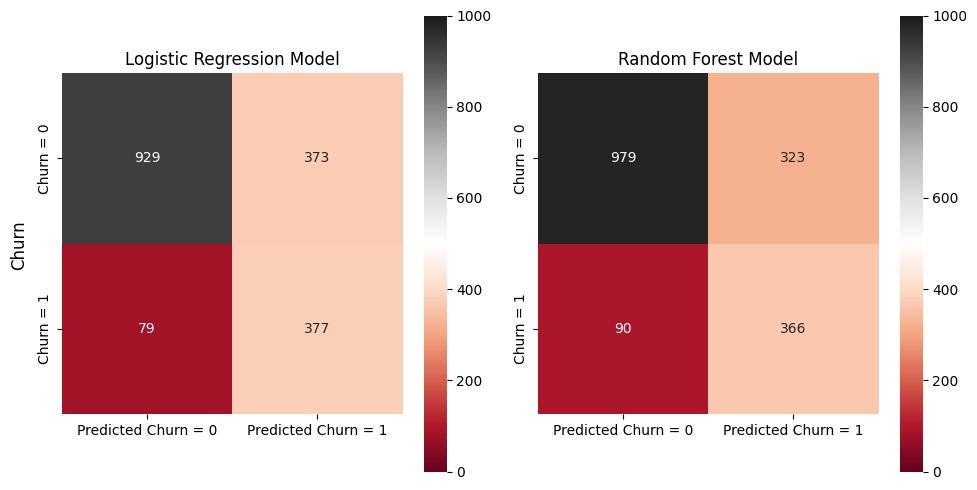

In [66]:
# Display heatmaps of the confusion matrices side by side
# Prepare figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Create heatmaps
sns.heatmap(
    cfm_log_reg, annot=True, fmt='',square=True, cmap="RdGy",
    vmin=0, vmax=1000, ax=ax1
)
sns.heatmap(
    cfm_forest, annot=True, fmt='',square=True, cmap="RdGy",
    vmin=0, vmax=1000, ax=ax2
)

# Add labels
ax1.set_title("Logistic Regression Model")
ax2.set_title("Random Forest Model")
fig.supylabel("Churn")

fig.tight_layout()

The visual difference between this pair of heatmaps is subtle, but there is a distinct difference between the hues in the Predicted Churn = 1 column in the Random Forest Model that is less pronounced for the Logistic Regression Model. Considering precision and recall in the context of the null hypothesis will help to determine which is preferable in this case.

### Precision and Recall
Precision is the proportion of predictions of the positive class that are correct, while recall describes how many instances of a class the model recognised. Both parameters are useful for evaluating the overall performance of a model. There is often a trade-off between precision and recall. The f1-score parameter combines precision and recall into one.

In [67]:
# Print the classification report for logistic regression
print(f"Logistic Regression")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1302
           1       0.50      0.84      0.62       456

    accuracy                           0.74      1758
   macro avg       0.71      0.77      0.71      1758
weighted avg       0.81      0.74      0.75      1758



Precision of 0.91 for Churn = 0 means that 91% of the cases the model predicted Churn = 0, the actual Churn was 0 and the model was correct. For Churn = 1, the model was correct in only 50% of cases.

Recall of 0.70 for Churn = 0 means that in all the cases where Churn = 0, the model correctly predicted the outcome in 70% of cases. For Churn = 1, the model correctly predicted that outcome in 81% of cases.

The f1-scores are fairly high, suggesting that this model does a reasonable job of predicting Churn = 0.

For imbalanced data, the weighted average should be used for establishing an overall performance for the model.

In [68]:
# Print the classification report for random forest
print(f"Random Forest")
print(classification_report(y_test, y_pred_forest))

Random Forest
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1302
           1       0.53      0.80      0.64       456

    accuracy                           0.77      1758
   macro avg       0.72      0.78      0.73      1758
weighted avg       0.82      0.77      0.78      1758



Overall the Random Forest Model has slightly higher weighted averages for precision and recall, suggesting it performs better.

### Model Evaluation
The null hypothesis, or aim of the model, is to predict which customers will remain with the company (ie Churn = 0). A false positive is a customer who is predicted to have Churn=0, but actually has Churn=1. In behavioural terms, this is a customer who is predicted to remain with the company but actually leaves. A false negative is a customer who is predicted to have Churn=1, but acutally has churn=0. In behavioural terms, this is a customer who is predicted to leave, but actually remains. In this scenario the false positive is important: these customers should be the target for customer-retention strategies. When false positives are more important than false negatives, recall is the most appropriate metric to use to inform model selection. Recall describes the proportion of actual positives correctly predicted to be positive by the model.

The weighted recall is higher for the Random Forest Model than the Logistic Regression Model, therefore the Random Forest Model is a better choice than the Logistic Regression Model. The confusion matrix and the OOB error both support the Random Forest Model as a good choice.

Reference: https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall 

## Conclusion
The random forest model is better suited to the task of predicting customer churn than a logistic regression model. The random forest can model complex relationships between variables, while logistic regression assumes linear relationships. This is important for problems involving behavioural science, where relationships are never linear: people live in different contexts and have different histories which influence their behaviour. Further, the supplied dataset was imbalanced, and this is handled better by a random forest, especially when bootstrapping is used for efficient use of datapoints. The analysis in this task supports this conclusion: the random forest model was found to outperform the logistic regression model, although the difference was small.

Reference: https://www.geeksforgeeks.org/machine-learning/logistic-regression-vs-random-forest-classifier/